# LC-level graph net with PU

In [24]:
import numpy as np
import torch

import sys
import torch.nn as nn
from torch.optim import SGD
from torch_cluster import knn_graph
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from reco.model import EdgeConvBlock

import sklearn.metrics as metrics

from reco.training import train_edge_pred, test_edge_pred, precision_recall_curve, roc_auc
from reco.loss import FocalLoss
from reco.datasetLCPU import LCGraphPU

ds_name = "CloseByGamma200PUFull"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [25]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [38]:
def knn_transform(data):
    data.edge_index = knn_graph(data.x[:,1:4], k=4, loop=False)
    return data

In [39]:
def create_mask(data):
    # extract the focus feature
    data.mask = (1 - data.x[:,0]).type(torch.bool)
    return data

In [40]:
transforms = T.Compose([knn_transform, create_mask])

ds = LCGraphPU(
    ds_name,
    data_root,
    raw_dir,
    transform=transforms,
    N_FILES=100,
    radius=10,
)

ds.processed_file_names

['LCGraphPU_CloseByGamma200PUFull_f100_r10_s0.2.pt']

In [41]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

# this is very nice - handles the dimensions automatically
train_dl = DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = DataLoader(test_set, batch_size=32, shuffle=True)

Train graphs: 1027, Test graphs: 114, total: 1141


In [42]:
print("Labels (one per layer-cluster):", len(ds.data.y))

Labels (one per layer-cluster): 343348


In [43]:
to_predict = []
for data in ds:
    to_predict += data.y[data.mask].tolist()

query_labels = np.array(to_predict)

positive = float(sum(query_labels > 0.8))
negative = len(query_labels) - positive
balance = positive / len(query_labels)

print(positive, negative)
print(f"dataset balance: {balance * 100:.2f}% (positive labels minus main trackster LCs)") 

17105.0 278714.0
dataset balance: 5.78% (positive labels minus main trackster LCs)


In [44]:
class LCGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.1):
        super(LCGraphNet, self).__init__()
        # particlenet

        hdim1 = 64
        in_dim2 = hdim1 + input_dim

        hdim2 = 128
        in_dim_fc = hdim2 + in_dim2
        hdim_fc = 256

        # EdgeConv
        self.graphconv1 = EdgeConvBlock(input_dim, hdim1)
        self.graphconv2 = EdgeConvBlock(in_dim2, hdim2)

        self.edgenetwork = nn.Sequential(
            nn.Linear(in_dim_fc, hdim_fc),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
            nn.Sigmoid()
        )

    def forward(self, X, edge_index):
        H = self.graphconv1(X, edge_index)
        H = self.graphconv2(H, edge_index)
        return self.edgenetwork(H).squeeze(-1)

In [45]:
model = LCGraphNet(input_dim=ds.data.x.shape[1])
epochs = 51
model_path = f"models/LCGraphNet.KNN.mask.64.128.256.256.ns.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.pt"

In [46]:
# %%script echo skipping

# alpha - percentage of negative edges
loss_func = FocalLoss(alpha=1-balance, gamma=2)

model = model.to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)

for epoch in range(epochs):

    train_loss, train_true, train_pred = train_edge_pred(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    train_auc = metrics.roc_auc_score((train_true > 0.8).astype(int), train_pred)
    scheduler.step()

    if epoch % 5 == 0:
        test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl)
        test_auc = metrics.roc_auc_score((test_true > 0.8).astype(int), test_pred)
        print(
            f"Epoch {epoch}:",
            f"\ttrain loss:{train_loss:.2f}\ttrain auc: {train_auc:.3f}",
            f"\t test loss:{test_loss:.2f} \t test auc: {test_auc:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)

Epoch 0: 	train loss:61.65	train auc: 0.536 	 test loss:4.03 	 test auc: 0.688
Epoch 5: 	train loss:14.39	train auc: 0.647 	 test loss:1.46 	 test auc: 0.772
Epoch 10: 	train loss:13.41	train auc: 0.726 	 test loss:1.30 	 test auc: 0.825
Epoch 15: 	train loss:13.54	train auc: 0.717 	 test loss:1.30 	 test auc: 0.833
Epoch 20: 	train loss:12.65	train auc: 0.779 	 test loss:1.26 	 test auc: 0.855
Epoch 25: 	train loss:12.95	train auc: 0.771 	 test loss:1.36 	 test auc: 0.860
Epoch 30: 	train loss:12.73	train auc: 0.800 	 test loss:1.37 	 test auc: 0.856
Epoch 35: 	train loss:12.45	train auc: 0.809 	 test loss:1.22 	 test auc: 0.869
Epoch 40: 	train loss:12.19	train auc: 0.815 	 test loss:1.35 	 test auc: 0.870
Epoch 45: 	train loss:11.77	train auc: 0.828 	 test loss:1.19 	 test auc: 0.875
Epoch 50: 	train loss:12.26	train auc: 0.820 	 test loss:1.21 	 test auc: 0.878


In [47]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


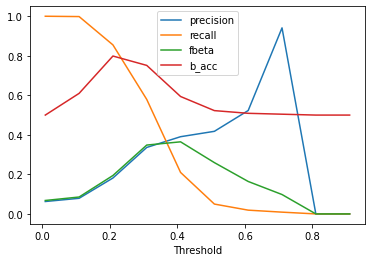

TP: 375, TN: 26122, FP: 585, FN: 1412
TH: 0.41 precision: 0.391 recall: 0.210 fbeta: 0.365 b_acc: 0.594


In [60]:
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.3, step=10)

In [61]:
print(roc_auc(model, device, test_dl))

0.8779772322118811


In [52]:
print(model_path)

models/LCGraphNet.KNN.mask.64.128.256.256.ns.51e-CloseByGamma200PUFull.10.0.2.100f.pt


## Results
- LCGraphNet.64.128.256.ns.201e-CloseByGamma200PUFull.10.0.2.464f.pt
    - AUC: 0.9726
    - TP: 22433, TN: 291361, FP: 11, FN: 7273
    - TH: 0.81 precision: 1.000 recall: 0.755 fbeta: 0.939 b_acc: 0.878
    - probably SOTA, but might need to remove "1" edges from the evaluation to make this fair
    - aggregated ROC: 0.942
- LCGraphNetKNN.64.128.256.ns.201e-CloseByGamma200PUFull.10.0.2.464f.pt
    - faster to train, comparable performance
    - AUC: 0.9787
    - TP: 21829, TN: 287975, FP: 43, FN: 7207
    - TH: 0.81 precision: 0.998 recall: 0.752 fbeta: 0.937 b_acc: 0.876
    - aggregate ROC: 0.962
- LCGraphNetKNN.64.128.256.256.ns.201e-CloseByGamma200PUFull.10.0.2.464f.pt
    - ParticleNet Arch
    - AUC: 0.981
    - TP: 22922, TN: 306228, FP: 164, FN: 8074
    - TH: 0.71 precision: 0.993 recall: 0.740 fbeta: 0.929 b_acc: 0.869
    - aggregate ROC: 0.972

In [53]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, fbeta_score, balanced_accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

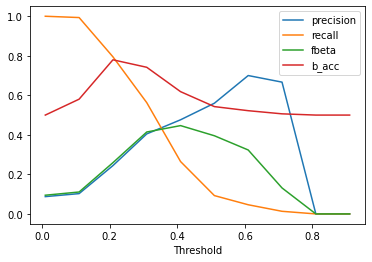

TP: 40, TN: 1531, FP: 44, FN: 111
TH: 0.41 precision: 0.476 recall: 0.265 fbeta: 0.447 b_acc: 0.618


In [58]:
th_values = [i / 100. for i in range(1, 100, 10)]

focus_metric = "fbeta"

beta = 0.3

result = {
    "precision": [],
    "recall": [],
    "fbeta": [],
    "b_acc": [],
}
cm = []

for th in th_values:
    pred = []
    y_true = []
    pred_means = []
    for data in test_dl:

        b = data.x
        l = data.y
        ei = data.edge_index.to(device)
        
        tracksters = set(data.trackster_index.tolist())
        
        b = b.to(device)
        l = l.reshape(-1)

        mask = data.mask

        model_pred = model(b, ei).detach().cpu().reshape(-1)
        
        for trackster in tracksters:
            idx = np.where(trackster == data.trackster_index)

            predict = mask[idx][0]

            if not predict:
                # exclude the main tracksters for fair evaluation
                continue

            pr = model_pred[idx]
            gt = l[idx]

            pred.append((pr.mean() > th).type(torch.int).item())
            y_true.append((gt.mean() > 0.8).type(torch.int).item())
            pred_means.append(pr.mean())

    result["precision"].append(precision_score(y_true, pred, zero_division=0))
    result["recall"].append(recall_score(y_true, pred))
    result["fbeta"].append(fbeta_score(y_true, pred, beta=beta))
    result["b_acc"].append(balanced_accuracy_score(y_true, pred))
    cm.append(confusion_matrix(y_true, pred).ravel())

plt.figure()
for k, v in result.items():
    plt.plot(th_values, v, label=k)

plt.xlabel("Threshold")
plt.legend()
plt.show()

bi = np.argmax(result[focus_metric])
decision_th = th_values[bi]

tn, fp, fn, tp = cm[bi]

print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"TH: {decision_th}", " ".join([f"{k}: {v[bi]:.3f}" for k, v in result.items()]))

In [59]:
# excluding the main tracksters
roc_auc_score(y_true, pred_means)

0.8592830863029539

## Conclusion
- k-nn if very slow, need to introduce a smarter way to deal with the edges
- need to add a "mask" to the data file and train with the mask
- otherwise it learns how to identify the tracksters we know they are the main trackster